In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
import joblib

# Step 1: Load dataset
df = pd.read_csv("/content/drive/MyDrive/ML_work/datafiles/station_data/palam_forecast_ready (4).csv")
df['datetime'] = pd.to_datetime(df['datetime'])



In [12]:
# Step 2: Remove unreliable columns (WBT has NaNs)
df.drop(columns=['WBT'], errors='ignore', inplace=True)



In [13]:
# Step 3: Sort and create lag features (7-day lags for forecasting)
df = df.sort_values('datetime')
target = 'heatwave'
features = [col for col in df.columns if col not in ['datetime', target]]

# Create lagged features
for feature in features:
    for lag in range(1, 8):  # 7-day lag
        df[f'{feature}_lag{lag}'] = df[feature].shift(lag)

In [14]:
# Step 4: Drop rows with NaNs (due to lagging)
df.dropna(inplace=True)

In [15]:
# Optional: Check available years after dropping NaNs
print("📅 Available years after lagging:", df['datetime'].dt.year.unique())


📅 Available years after lagging: [1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983
 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997
 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2011 2013
 2014 2020 2021 2022 2024]


In [16]:
# Step 5: Split into train/test
train_df = df[df['datetime'].dt.year < 2024]
test_df = df[df['datetime'].dt.year == 2024]

X_train = train_df.drop(columns=['datetime', target])
y_train = train_df[target]
X_test = test_df.drop(columns=['datetime', target])
y_test = test_df[target]

print("✅ Train shape:", X_train.shape)
print("✅ Test shape (2024 June):", X_test.shape)


✅ Train shape: (5109, 24)
✅ Test shape (2024 June): (30, 24)


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

# Step 6: Train classifier
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=7,
    min_samples_leaf=4,
    max_features='sqrt',
    class_weight='balanced',  # Handles imbalance in 0/1
    random_state=42
)

rf.fit(X_train, y_train)

# Step 7: Predict and evaluate on 2024 June data
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]  # Optional: probabilities

# Classification metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cv_score = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1').mean()

print("\n📌 Classification Report:")
print(classification_report(y_test, y_pred))
print("📌 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"📌 Accuracy (2024): {accuracy:.4f}")
print(f"📌 F1 Score (2024): {f1:.4f}")
print(f"📌 CV F1 Score (Train): {cv_score:.4f}")



📌 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        23
           1       0.88      1.00      0.93         7

    accuracy                           0.97        30
   macro avg       0.94      0.98      0.96        30
weighted avg       0.97      0.97      0.97        30

📌 Confusion Matrix:
 [[22  1]
 [ 0  7]]
📌 Accuracy (2024): 0.9667
📌 F1 Score (2024): 0.9333
📌 CV F1 Score (Train): 0.6875


In [24]:
import joblib
joblib.dump(rf, "forecast_model_palam.pkl")


['forecast_model_palam.pkl']

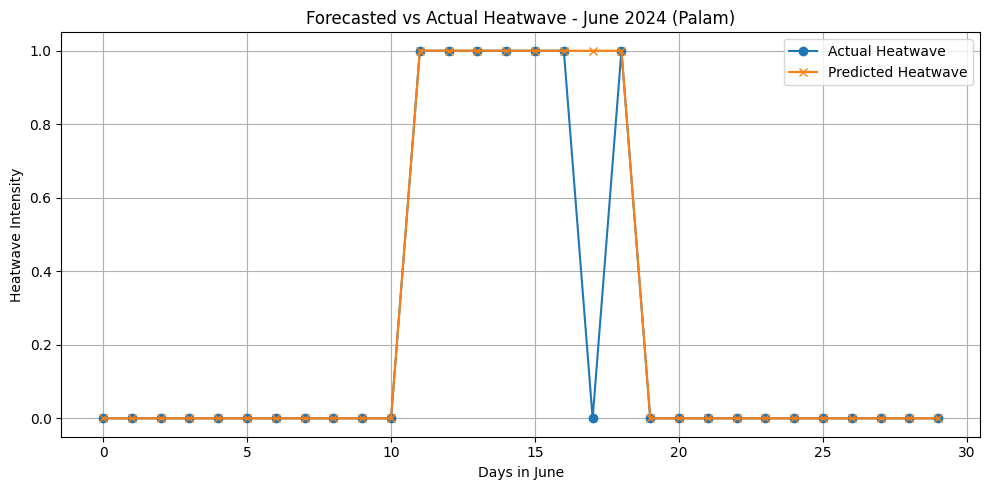

In [23]:
import matplotlib.pyplot as plt

# Assuming y_test is the actual heatwave
# and y_pred is the predicted heatwave

plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual Heatwave', marker='o')
plt.plot(y_pred, label='Predicted Heatwave', marker='x')
plt.title('Forecasted vs Actual Heatwave - June 2024 (Palam)')
plt.xlabel('Days in June')
plt.ylabel('Heatwave Intensity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


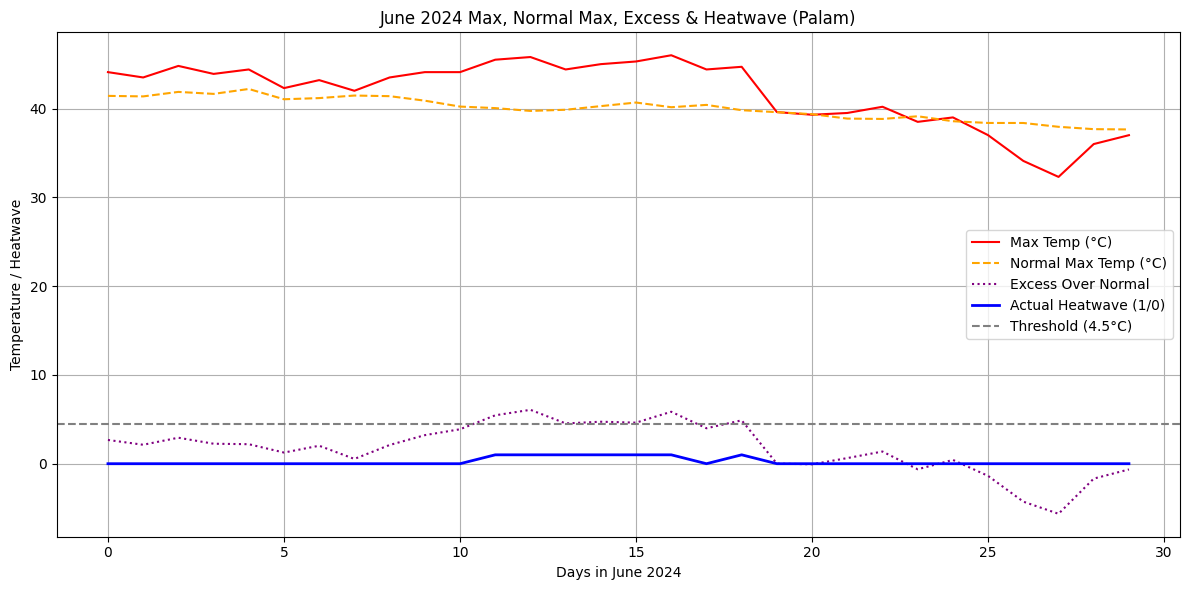

In [28]:
import matplotlib.pyplot as plt

# Filter June 2024 data from your main DataFrame
june_df = df[
    (df['datetime'].dt.year == 2024) &
    (df['datetime'].dt.month == 6)
].reset_index(drop=True)

# Plot max temp, normal max, excess and heatwave flags
plt.figure(figsize=(12,6))
plt.plot(june_df.index, june_df['max'], label='Max Temp (°C)', color='red')
plt.plot(june_df.index, june_df['normal_max'], label='Normal Max Temp (°C)', color='orange', linestyle='--')
plt.plot(june_df.index, june_df['max'] - june_df['normal_max'], label='Excess Over Normal', color='purple', linestyle=':')
plt.plot(june_df.index, june_df['heatwave'], label='Actual Heatwave (1/0)', color='blue', linewidth=2)

plt.axhline(4.5, color='gray', linestyle='--', label='Threshold (4.5°C)')
plt.xlabel("Days in June 2024")
plt.ylabel("Temperature / Heatwave")
plt.title("June 2024 Max, Normal Max, Excess & Heatwave (Palam)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
print([var for var in dir() if isinstance(eval(var), pd.DataFrame)])


['X_test', 'X_train', 'df', 'test_df', 'train_df']
